In [1]:
%load_ext memory_profiler
import cProfile

from string import ascii_uppercase

import numpy as np
import pandas as pd

cols = list(ascii_uppercase[:10])
np.random.seed(42)
data = np.random.randint(1, 100, size=(100_000, 10))
df = pd.DataFrame(data, columns=cols)
df.head()

,A,B,C,D,E,F,G,H,I,J
0,52,93,15,72,61,21,83,87,75,75
1,88,24,3,22,53,2,88,30,38,2
2,64,60,21,33,76,58,22,89,49,91
3,59,42,92,60,80,15,62,62,47,62
4,51,55,64,3,51,7,21,73,39,18


In [4]:
%%timeit
# groupby count values are floats
df.groupby(['A', 'B'])['C'].count().unstack().fillna(0)

9.2 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
# pivot_table count values are integers
df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)

33.3 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit
# crosstab count values are integers
pd.crosstab(df.A, df.B)

79.4 ms ± 891 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
def profile_call(func, *args, **kwargs):
    profile = cProfile.Profile()
    profile.enable()
    func(*args, **kwargs)
    profile.disable()
    stats = profile.getstats()
    df_profile = pd.DataFrame(stats, columns=['code', 'callcount', 'reccallcount', 'totaltime', 'inlinetime', 'calls'])
    df_profile.sort_values('totaltime', ascending=False, inplace=True)
    return df_profile

In [11]:
df_profile = profile_call(pd.crosstab, df.A, df.B)
df_profile.head()

,code,callcount,reccallcount,totaltime,inlinetime,calls
44,"<code object crosstab at 0x7fa39f8ddf60, file ...",1,0,0.121772,0.000030,"[(<code object __setitem__ at 0x7fa3a01fcc90, ..."
380,"<code object pivot_table at 0x7fa3a0208f60, fi...",1,0,0.118237,0.000030,[(<code object _handle_fromlist at 0x7fa3e8a9e...
42,"<code object pivot_table at 0x7fa39f8d7a50, fi...",1,0,0.118205,0.000078,"[(<code object sort_index at 0x7fa3a0208660, f..."
91,"<code object aggregate at 0x7fa39fa251e0, file...",1,0,0.075596,0.000004,"[(<code object aggregate at 0x7fa39fe5c780, fi..."
96,"<code object aggregate at 0x7fa39fe5c780, file...",1,0,0.075592,0.000011,"[(<code object _aggregate at 0x7fa3a07c9db0, f..."


In [12]:
df_profile = profile_call(df.pivot_table, values='C', index='A', columns='B', aggfunc='count', fill_value=0)
df_profile.head()

,code,callcount,reccallcount,totaltime,inlinetime,calls
342,"<code object pivot_table at 0x7fa3a0208f60, fi...",1,0,0.057103,0.000040,[(<code object _handle_fromlist at 0x7fa3e8a9e...
48,"<code object pivot_table at 0x7fa39f8d7a50, fi...",1,0,0.057060,0.000117,"[(<code object dropna at 0x7fa3a0208270, file ..."
150,"<code object apply at 0x7fa39ffb2300, file ""/h...",6,0,0.032086,0.000060,"[(<code object fillna at 0x7fa39ffffb70, file ..."
339,"<code object fillna at 0x7fa3a0203ae0, file ""/...",1,0,0.031380,0.000005,"[(<code object fillna at 0x7fa3a00ff780, file ..."
325,"<code object fillna at 0x7fa3a00ff780, file ""/...",1,0,0.031375,0.000018,"[(<code object fillna at 0x7fa39ffb2ae0, file ..."


In [13]:
import timeit
timeit.timeit('pd.crosstab(df.A, df.B)', number=1, globals=globals())

0.08762635200037039

In [24]:
timeit.timeit('''df.groupby(['A', 'B'])['C'].count().unstack().fillna(0)''', number=1, globals=globals())

0.011541660998773295

In [100]:
from collections import defaultdict

durations = defaultdict(list)

for size in np.logspace(3, 5, 2): # USE 3, 7, 5
    size = int(size)
    repetitions = 1
    data = np.random.randint(1, 100, size=(size, 10))
    df = pd.DataFrame(data, columns=cols)
    duration = timeit.timeit('pd.crosstab(df.A, df.B)', number=repetitions, globals=globals()) / repetitions
    durations['crosstab'].append({'size': size, 'duration': duration})

In [101]:
df = pd.DataFrame(durations['crosstab']).set_index('size')

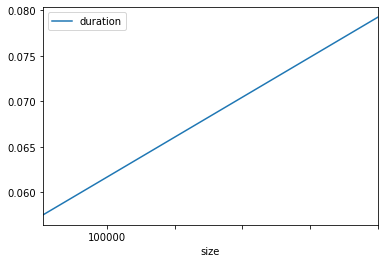

In [102]:
ax = df.plot()
ax.set_xticklabels(df.index);

In [79]:
df

,duration
size,
1000.0,0.048441
10000.0,0.061867
100000.0,0.077792
1000000.0,0.148615
10000000.0,1.215916
